<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow

Note: you may need to restart the kernel to use updated packages.


<h2>INTRODUZIONE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Il problema principale riguarda l'interpretazione delle <strong>mutazioni genetiche</strong> nei <strong>tumori</strong>. Quando si sequenzia il <strong>DNA</strong> di un tumore, emergono migliaia di mutazioni. Tuttavia, non tutte sono rilevanti per la <strong>crescita del tumore</strong>. Alcune mutazioni, chiamate "<strong>driver</strong>", favoriscono la proliferazione delle <strong>cellule tumorali</strong>, mentre altre, chiamate "<strong>passenger</strong>", sono neutre e non influenzano lo sviluppo del tumore. Distinguere tra queste due categorie è fondamentale per sviluppare <strong>terapie personalizzate</strong> ed efficaci.
</p>
<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Attualmente, questo lavoro viene svolto manualmente da <strong>patologi clinici</strong>, che analizzano ogni mutazione sulla base delle informazioni disponibili nella <strong>letteratura scientifica</strong>. Questo processo è estremamente <strong>laborioso</strong> e richiede molto <strong>tempo</strong>, dato che ogni mutazione deve essere valutata attentamente.
</p>
<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Il <strong>Memorial Sloan Kettering Cancer Center (MSKCC)</strong>, uno dei principali <strong>centri oncologici</strong> al mondo, ha costruito un'ampia <strong>base di dati annotata</strong> da esperti in cui migliaia di mutazioni sono state già classificate da <strong>ricercatori</strong> e <strong>oncologi</strong>. L'obiettivo è sviluppare un <strong>sistema automatizzato</strong>, basato su tecnologie di <strong>Machine Learning</strong>, che possa utilizzare questa base di dati per <strong>classificare automaticamente</strong> le nuove mutazioni genetiche. Questo sistema permetterebbe di accelerare il processo di <strong>interpretazione genetica</strong>, riducendo il lavoro manuale e facilitando l'adozione della <strong>medicina di precisione</strong> nel trattamento del <strong>cancro</strong>.
</p>
<br>


<h2>IMPORTAZIONE LIBRERIE</h2>

In [40]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer 
from collections import Counter

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score, f1_score)

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time

# Ignorare avvisi
warnings.filterwarnings('ignore')


<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

Il set di dati è composto da due file: 

<h3>training_variants:</h3>
<p>Questo file contiene le informazioni strutturate sulle mutazioni genetiche.</p>
<p>Ogni riga rappresenta una singola mutazione ed è composta da quattro campi:</p>
<ul>
    <li><strong>ID</strong>: Un identificativo univoco che collega le informazioni genetiche alle prove cliniche corrispondenti nel file <em>training_text</em>.</li>
    <li><strong>Gene</strong>: Il gene in cui è avvenuta la mutazione.</li>
    <li><strong>Variation</strong>: La variazione amminoacidica associata alla mutazione.</li>
    <li><strong>Class</strong>: La classe (da 1 a 9) in cui la mutazione è stata classificata. Queste classi rappresentano diverse categorie che descrivono la rilevanza clinica della mutazione.</li>
</ul>

<h3>training_text:</h3>
<p>Questo file contiene le prove cliniche sotto forma di testo, utilizzate dagli esperti per classificare le mutazioni.</p>
<p>Ogni riga corrisponde a una mutazione genetica, con due campi:</p>
<ul>
    <li><strong>ID</strong>: Lo stesso identificativo presente nel file <em>training_variants</em>, che permette di collegare una mutazione specifica al testo clinico corrispondente.</li>
    <li><strong>Text</strong>: Il testo che descrive le prove cliniche associate a quella specifica mutazione. Questa parte è fondamentale per l'algoritmo, poiché fornisce informazioni dettagliate che gli esperti hanno utilizzato per la classificazione.</li>
</ul>

<h3>Collegamento tra i file</h3>
<p>I due file sono collegati tramite il campo <strong>ID</strong>. Ad esempio, la mutazione con <strong>ID=15</strong> nel file <em>training_variants</em> corrisponde alla descrizione delle prove cliniche con <strong>ID=15</strong> nel file <em>training_text</em>. In questo modo, l'algoritmo può associare una mutazione genetica specifica con le prove cliniche testuali utilizzate per classificarla.</p>


<strong>Source:</strong> https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

In [3]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


<br>
<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Da una breve analisi della struttura dei 2 file, si osserva che <strong>entrambi</strong> i file hanno <strong>3321 righe</strong>, il che significa che ci sono <strong>3321 mutazioni genetiche</strong> con <strong>prove cliniche</strong> corrispondenti. Si nota come il <strong>dataset di training</strong> fornisce un numero moderato di esempi per l'<strong>addestramento</strong> del <strong>modello</strong>, rendendo possibile un buon livello di <strong>apprendimento</strong>, ma lasciando aperta la necessità di <strong>tecniche</strong> per gestire il <strong>testo</strong> probabilmente molto <strong>variegato</strong> e ricco di <strong>dettagli tecnici</strong>.
</p><br>


In [4]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
training_text.head()

,ID,text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


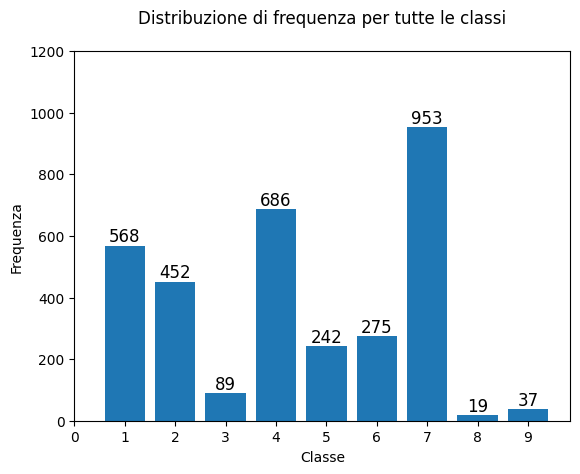

In [7]:
# Conta i valori delle classi e li ordina
plot_dist = df['Class'].value_counts().sort_index()

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(plot_dist.index, plot_dist.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione di frequenza per tutte le classi', loc='center', pad=20)
ax.set_xlabel('Classe')
ax.set_ylabel('Frequenza')

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite massimo dell'asse y a 1200
ax.set_ylim(0, 1200)


# Imposta i tick dell'asse x per tutte le classi
ax.set_xticks(range(0, 10))  # Imposta tick per ogni classe

# Mostra il grafico
plt.show()



<h2>PRE-ELABORAZIONE DEL TESTO</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
    La <strong>pre-elaborazione del testo</strong> è un passaggio fondamentale nell'analisi del testo e nell'apprendimento automatico, soprattutto quando si ha a che fare con grandi quantità di dati testuali, come le prove cliniche in questo progetto. Dalle prime proiezioni, notiamo la presenza di caratteri o simboli che sarebbe preferibile escludere dagli algoritmi per ragioni di <strong>efficienza</strong> e <strong>pesantezza</strong>. Un altro aspetto importante sono le <strong>stop word</strong>, ovvero parole comuni che ricorrono frequentemente nella lingua ma che spesso non contribuiscono in modo significativo al significato di una frase, come articoli, preposizioni e congiunzioni.
</p>

<h2>Scopo della rimozione delle stop word:</h2>
<ul>
    <li>
        <strong>Riduzione della dimensionalità dei dati:</strong> Le stop word costituiscono una parte significativa di qualsiasi testo. Rimuovendole, si riduce la dimensione dello spazio delle <strong>features</strong>, rendendo il processo di apprendimento automatico più <strong>efficiente</strong>.
    </li><br>
    <li>
        <strong>Miglioramento dell'accuratezza del modello:</strong> Le stop word spesso non contengono informazioni rilevanti per la classificazione. Rimuovendole, si aiuta l'algoritmo di apprendimento automatico a concentrarsi su parole e frasi più <strong>significative</strong>, migliorando così l'accuratezza <strong>predittiva</strong>.
    </li><br>
    <li>
        <strong>Evitare il sovradattamento:</strong> Mantenere le stop word nei dati di addestramento potrebbe portare il modello a dare troppo peso a queste parole comuni, con il rischio di <strong>sovradattamento</strong> ai dati di addestramento e scarse prestazioni su dati non visti.
    </li><br>
</ul>


In [8]:
# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

wordnet_lemmatizer = WordNetLemmatizer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e lemmatizzazione
    tokens = word_tokenize(text)
    filtered_tokens = [
        wordnet_lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)



def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))

In [9]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [01:35<00:00, 34.79it/s]


In [10]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [11]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text
1109,1109,FANCA,S1088F,1,
1277,1277,ARID5B,Truncating Mutations,1,
1407,1407,FGFR3,K508M,6,
1639,1639,FLT1,Amplification,6,
2755,2755,BRAF,G596C,7,


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
    Possiamo vedere che molte righe contengono <strong>dati mancanti</strong>. Cosa fare con questi valori mancanti? Un'opzione potrebbe essere <strong>eliminare</strong> queste righe, oppure si potrebbe effettuare un'<strong>imputazione</strong>, ovvero cercare di rimpiazzare queste righe sfruttando le altre feature presenti.
    <br>In questo caso, per semplificare e rendere più puliti i dati, procediamo con <strong>l'eliminazione</strong> delle righe che hanno valori mancanti.
</p>


In [12]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

# Cerchiamo nuovamente righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Notiamo che la <b>rimozione</b> è stata eseguita correttamente, adesso otteniamo una breve vista delle <b>caratteristiche</b> delle righe di testo più <b>rilevanti</b>.
</p>


In [13]:
def word_count_summary(df, text_column):
    # Calcola il numero di parole in ogni riga
    word_counts = df[text_column].apply(lambda x: len(str(x).split()))
    
    # Trova la riga con il maggior numero di parole
    max_index = word_counts.idxmax()  # Ottieni l'indice della riga con il massimo
    max_words = word_counts.max()
    row_with_max_words = df.iloc[max_index]  # Usa il metodo iloc per accedere alla riga

    # Trova la riga con il minor numero di parole
    min_index = word_counts.idxmin()  # Ottieni l'indice della riga con il minimo
    min_words = word_counts.min()
    row_with_min_words = df.iloc[min_index]  # Usa il metodo iloc per accedere alla riga

    # Restituisce i risultati
    return {
        'average': word_counts.mean(),
        'max_id': row_with_max_words['ID'],  
        'max_words': max_words,
        'min_id': row_with_min_words['ID'],
        'min_words': min_words
    }

summary = word_count_summary(df, 'text')  

# Stampa i risultati
print(f"\nNumero medio di parole per riga: {summary['average']:.2f}")
print(f"ID riga con più parole: {summary['max_id']} (Numero di parole: {summary['max_words']})")
print(f"ID riga con meno parole: {summary['min_id']} (Numero di parole: {summary['min_words']})")



Numero medio di parole per riga: 5836.78
ID riga con più parole: 1196 (Numero di parole: 48707)
ID riga con meno parole: 1616 (Numero di parole: 30)


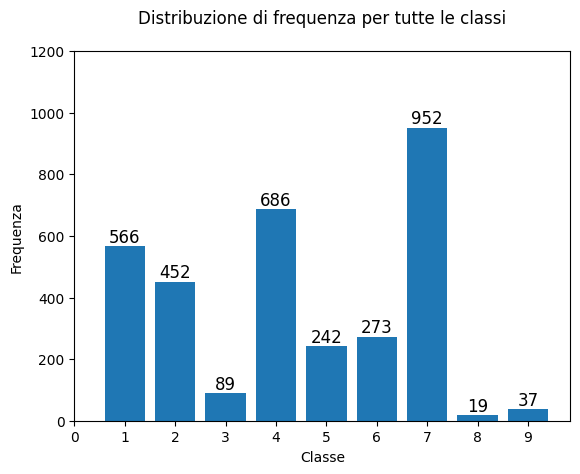

In [14]:
# Conta i valori delle classi e li ordina
plot_dist = df['Class'].value_counts().sort_index()

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(plot_dist.index, plot_dist.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione di frequenza per tutte le classi', loc='center', pad=20)
ax.set_xlabel('Classe')
ax.set_ylabel('Frequenza')

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite massimo dell'asse y a 1200
ax.set_ylim(0, 1200)


# Imposta i tick dell'asse x per tutte le classi
ax.set_xticks(range(0, 10))  # Imposta tick per ogni classe

# Mostra il grafico
plt.show()


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
    Da questa seconda visualizzazione, possiamo notare come la distribuzione continui a risultare <strong>sbilanciata</strong> verso alcune classi, con insufficienza di esempi per le classi 8 e 9. Durante l'addestramento, questo problema può essere affrontato utilizzando <strong>pesi bias</strong> o, in alternativa, rimuovendo alcuni dei dati dalle classi <strong>sovra-rappresentate</strong>.
    <br><br>
    Nonostante ciò, già l'applicazione della <strong>pre-elaborazione del testo</strong> e la rimozione delle righe con dati mancanti hanno contribuito a una variazione nella distribuzione delle classi. Procediamo ora con un'analisi più approfondita delle <strong>features</strong> del dataset delle varianti.
</p><br>


<h2>ANALISI DELLE FEATURES:</h2>

<h3> - GENI</h3>

In [15]:
unique_genes = df['Gene'].value_counts()

# Stampa del numero di geni unici
print('Numero di Geni Unici:', unique_genes.shape[0])
print(' ')
# Stampa dei top 5 geni più frequenti 
print("Top 5 Geni più frequenti:")
print(' ')
for gene, count in unique_genes.head(5).items():
    print(f'{gene}: {count}')


Numero di Geni Unici: 262
 
Top 5 Geni più frequenti:
 
BRCA1: 264
TP53: 163
EGFR: 141
PTEN: 126
BRCA2: 125


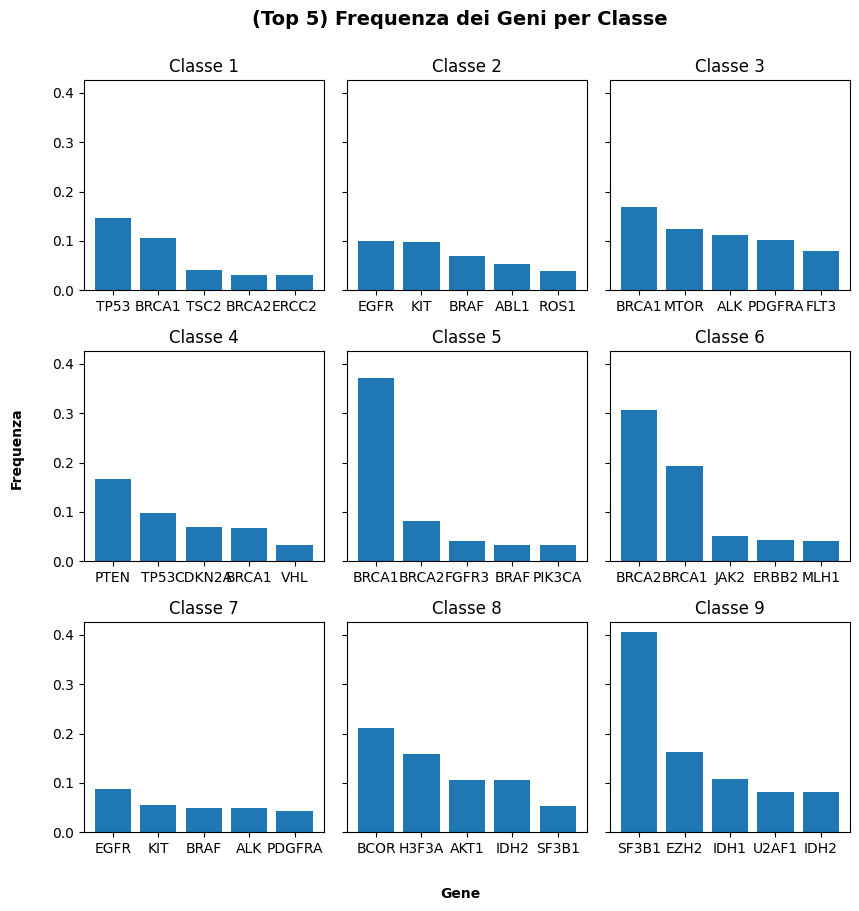

In [16]:
# Creazione dei sottotitoli per il grafico
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 9))

# Normalizzazione dei conteggi per una migliore comparazione
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

# Creazione dei grafici per ogni classe
for idx, g in enumerate(df.groupby('Class')):
    label, val = normalize_group(g[1]["Gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5], tick_label=label[:5]) 
    ax.set_title("Classe {}".format(g[0]))

# Etichette
fig.text(0.5, 0.97, '(Top 5) Frequenza dei Geni per Classe', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequenza', va='center', rotation='vertical', fontweight='bold')

# Ottimizzazione del layout
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])


<h3> - VARIANTI</h3>

In [17]:
unique_variations = df['Variation'].value_counts()

# Stampa del numero di Varianti uniche
print('Numero di Varianti Uniche:', unique_variations.shape[0])
print(' ')

# Stampa delle top 10 Varianti più frequenti senza "name" e "dtype"
print("Top 5 Varianti più frequenti:")
print(' ')
for variation, count in unique_variations.head(10).items():
    print(f'{variation}: {count}')

Numero di Varianti Uniche: 2993
 
Top 5 Varianti più frequenti:
 
Truncating Mutations: 92
Deletion: 74
Amplification: 70
Fusions: 34
Overexpression: 6
G12V: 4
Q61L: 3
E17K: 3
T58I: 3
Q61R: 3


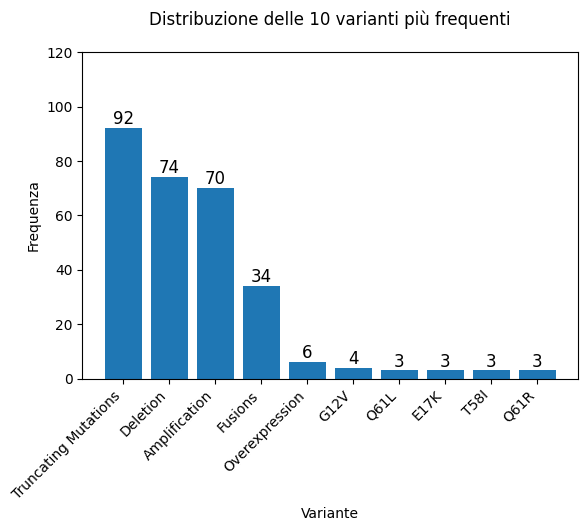

In [18]:
# Conta i valori delle varianti e prendi solo le prime 10 più frequenti
variations_data = df['Variation'].value_counts().head(10)

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(variations_data.index, variations_data.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione delle 10 varianti più frequenti', loc='center', pad=20)
ax.set_xlabel('Variante')  # Titolo dell'asse x
ax.set_ylabel('Frequenza')  # Titolo dell'asse y

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite dell'asse y e i tick
ax.set_ylim(0, 120)  # Imposta il limite massimo dell'asse y a 120
ax.set_yticks(range(0, 121, 20))  # Imposta i tick dell'asse y da 0 a 120, con intervallo di 20

# Personalizzazione del font
plt.xticks(rotation=45, ha='right')  # Ruota le etichette dell'asse x se necessario
plt.subplots_adjust(bottom=0.2)  # Aggiungi spazio in basso se le etichette sono lunghe

# Mostra il grafico
plt.show()


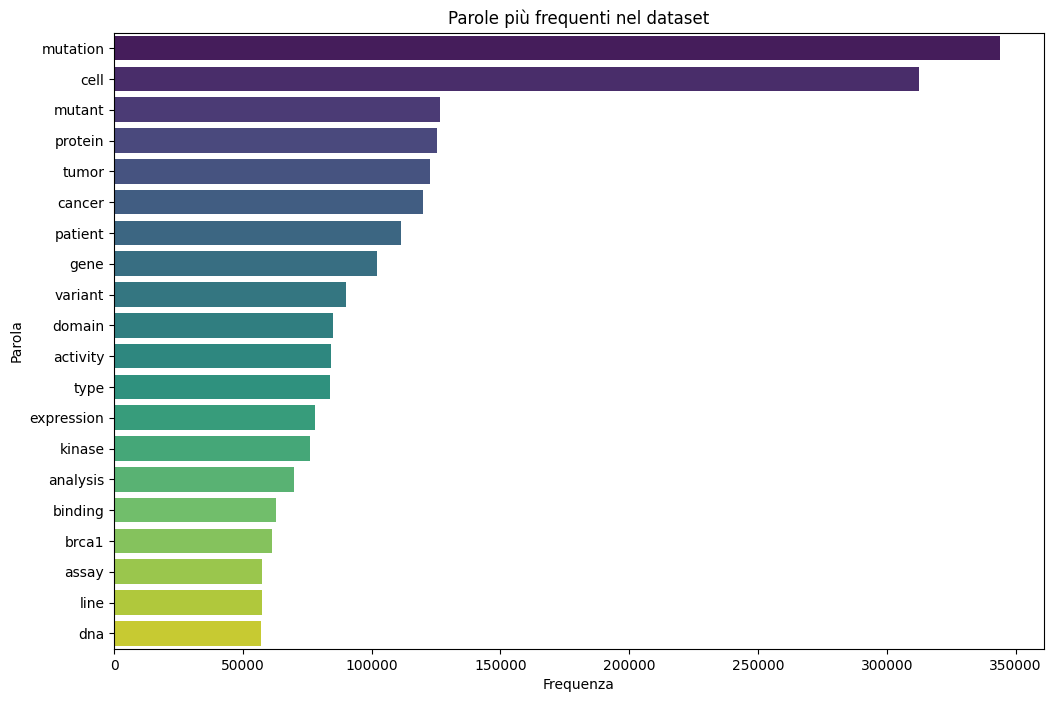

In [19]:

# Unione di tutto il testo in una singola stringa
all_text = ' '.join(df['text'].dropna())

# Tokenizzazione del testo e conteggio delle parole
tokens = all_text.split()  # Dividi il testo in parole
word_counts = Counter(tokens)  # Conta la frequenza di ogni parola

# Converti il conteggio delle parole in un DataFrame ordinato
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Filtra per le parole più frequenti (ad esempio le prime 20)
top_words_df = word_freq_df.head(20)

# Crea il grafico delle parole ordinate per frequenza
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='word', x='frequency', palette='viridis')
plt.xlabel('Frequenza')
plt.ylabel('Parola')
plt.title('Parole più frequenti nel dataset')
plt.show()


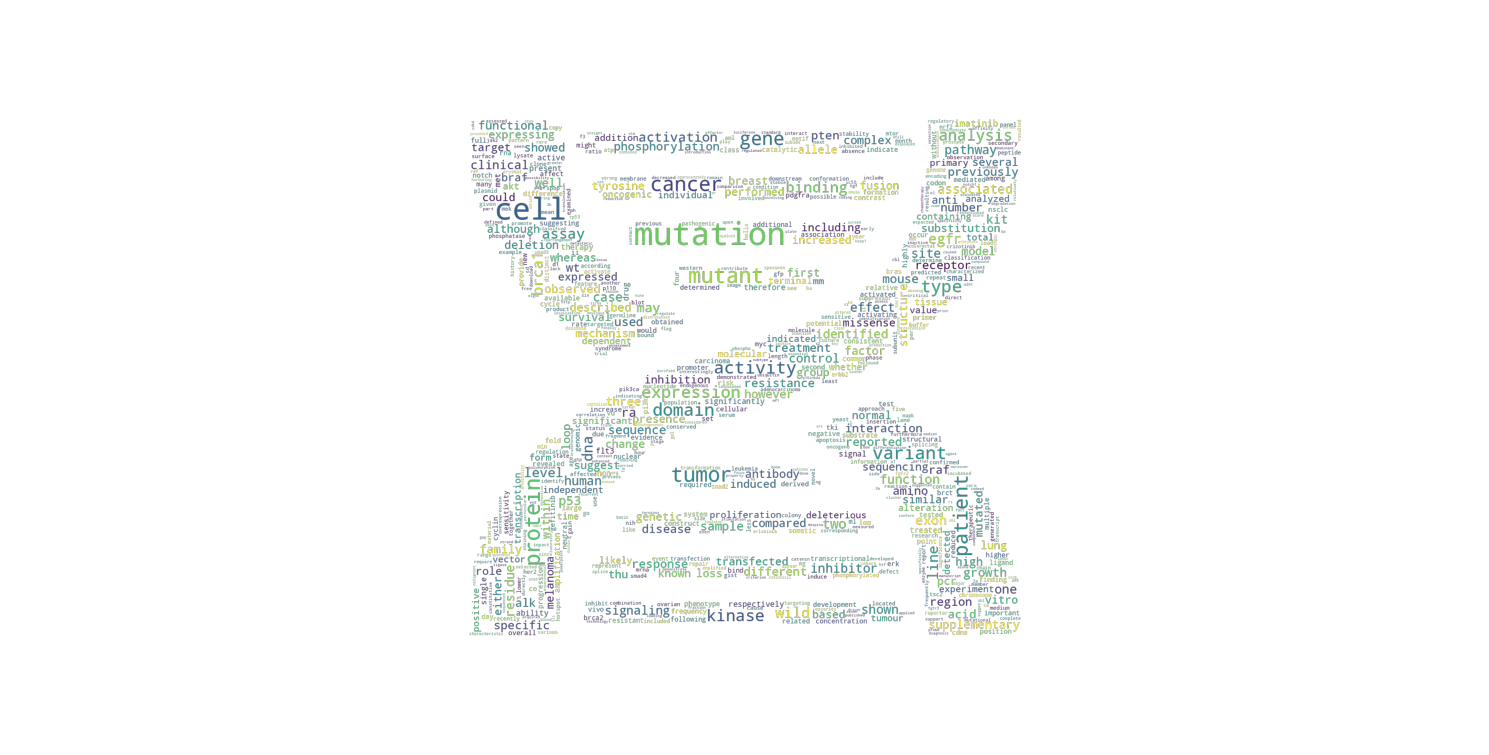

In [29]:
from PIL import Image


# Funzione per ridimensionare l'immagine
def resize_image(np_img, new_size):
    img = Image.fromarray(np_img)
    img = img.resize(new_size, Image.LANCZOS)  # Usa il filtro LANCZOS per un ridimensionamento di alta qualità
    return np.array(img)

# Carica e ridimensiona l'immagine della maschera
mask_image = np.array(Image.open('/Users/diego/Desktop/TIROCINIO/DATASET/dna.png').convert('L'))
mask_image = resize_image(mask_image, (4000, 2000))

# Unisci tutto il testo in una singola stringa
all_text = ' '.join(df['text'].dropna())

# Genera la WordCloud con stile personalizzato
wordcloud = WordCloud(
    max_font_size=140,
    min_font_size=8,
    max_words=1000,  # Numero massimo di parole
    width=mask_image.shape[1], 
    height=mask_image.shape[0],
    prefer_horizontal=0.9,
    relative_scaling=0.52,
    background_color=None,
    colormap='viridis',
    stopwords=stop_words,
    mask=mask_image,
    mode="RGBA",  # Modalità per supporto trasparenza
    collocations=False
).generate(all_text)

# Visualizza la WordCloud
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.tight_layout()
plt.imshow(wordcloud, interpolation="hanning")
plt.show()

<h2> MODELLAZIONE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Dopo aver completato le operazioni di <b>Analisi Esplorativa dei Dati (EDA)</b> e di <b>Natural Language Processing (NLP)</b>, siamo pronti a procedere con la <b>modellazione</b>. Queste fasi preliminari ci hanno fornito le informazioni necessarie per scegliere i modelli più adatti e ottimizzare le loro performance.
</p>


<h3> SUDDIVISIONE DEL DATASET IN DATI DI TRAINING E DI TEST </h3>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
In questo codice, i testi vengono trasformati in vettori numerici utilizzando la tecnica <strong>TF-IDF</strong> (Term Frequency-Inverse Document Frequency), che valuta l'importanza delle parole nei documenti. Successivamente, i dati vengono suddivisi in <strong>training set</strong> e <strong>test set</strong>: il training set verrà utilizzato per addestrare il modello, mentre il test set servirà per valutarne le prestazioni. Questa suddivisione consente di verificare come il modello <strong>generalizza</strong> su dati mai visti prima.
</p>
<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Il parametro <strong>random_state=42</strong> viene utilizzato per garantire che la suddivisione dei dati sia sempre la stessa ogni volta che viene eseguito il codice. Questo rende i risultati riproducibili e facilita il confronto tra i diversi modelli utilizzati, poiché il campionamento casuale avviene nello stesso modo ogni volta.
</p>

In [30]:
# Vettorizzazione con TF-IDF
tfidf = TfidfVectorizer(max_features=1000)  # Puoi modificare max_features a seconda del dataset
X_text = tfidf.fit_transform(df["text"]).toarray()

# Concatena le features testuali con le variabili numeriche e categoriali
X = np.concatenate((df[["Gene", "Variation"]].values, X_text), axis=1)
y = df["Class"]

# Codifica delle variabili categoriali
label_encoder = LabelEncoder()
X[:, 0] = label_encoder.fit_transform(X[:, 0])  # Codifica la colonna "Gene"
X[:, 1] = label_encoder.fit_transform(X[:, 1])  # Codifica la colonna "Variation"
y = label_encoder.fit_transform(y)  # Codifica la classe target

# Suddivisione in training, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [32]:
# Crea un DataFrame di training unendo i dati di X e y
train_df = pd.DataFrame(X_train)
train_df['Class'] = y_train

# Separazione delle feature e del target
X_train_features = train_df.drop('Class', axis=1)
y_train_labels = train_df['Class']

# Applicazione di SMOTE per il bilanciamento delle classi
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_features, y_train_labels)

# Converti in array se richiesto
X_train_balanced = X_train_balanced.values
y_train_balanced = y_train_balanced.values

# Standardizzazione delle features
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Applicazione di SVD per ridurre la dimensionalità
svd = TruncatedSVD(n_components=100, random_state=42)  # Scegli il numero di componenti
X_train_balanced = svd.fit_transform(X_train_balanced)
X_val = svd.transform(X_val)
X_test = svd.transform(X_test)

In [36]:
# Numero di righe e colonne nel dataset di training
num_righe_train, num_colonne_train = X_train_balanced.shape
print(f"Dataset di training: {num_righe_train} righe, {num_colonne_train} colonne")

# Numero di righe e colonne nel dataset di validazione
num_righe_val, num_colonne_val = X_val.shape
print(f"Dataset di validazione: {num_righe_val} righe, {num_colonne_val} colonne")

# Numero di righe e colonne nel dataset di test
num_righe_test, num_colonne_test = X_test.shape
print(f"Dataset di test: {num_righe_test} righe, {num_colonne_test} colonne")


Dataset di training: 5994 righe, 100 colonne
Dataset di validazione: 497 righe, 100 colonne
Dataset di test: 498 righe, 100 colonne


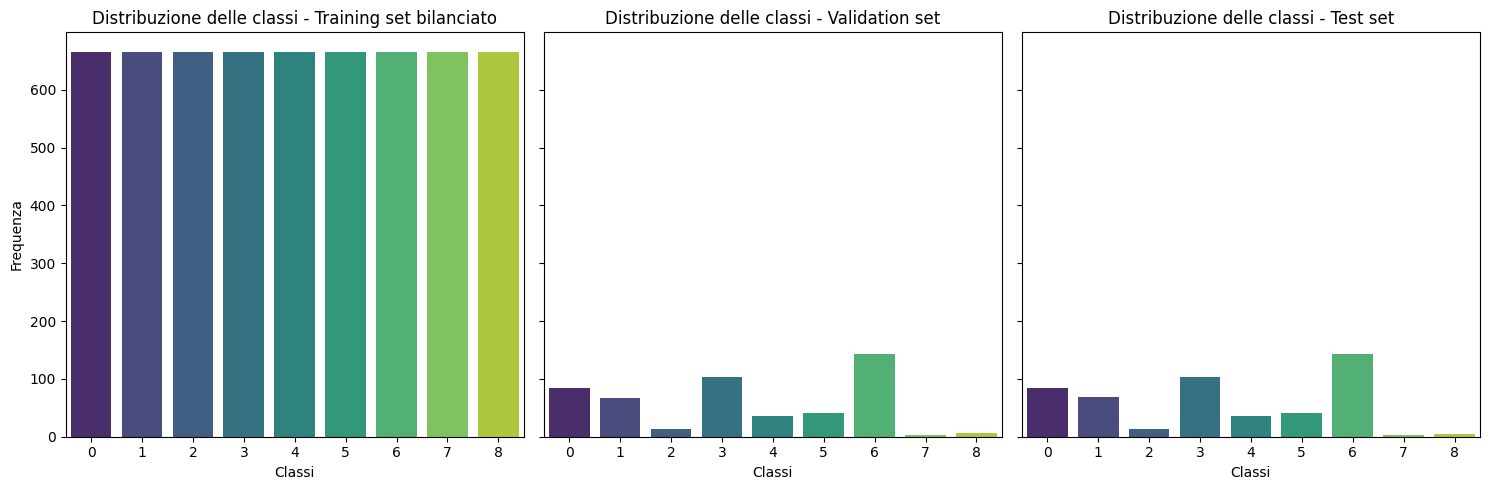

In [37]:
# Configura il layout dei grafici
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Grafico per il dataset di training bilanciato
sns.countplot(x=y_train_balanced, ax=axes[0], palette="viridis")
axes[0].set_title("Distribuzione delle classi - Training set bilanciato")
axes[0].set_xlabel("Classi")
axes[0].set_ylabel("Frequenza")

# Grafico per il dataset di validazione
sns.countplot(x=y_val, ax=axes[1], palette="viridis")
axes[1].set_title("Distribuzione delle classi - Validation set")
axes[1].set_xlabel("Classi")
axes[1].set_ylabel("")

# Grafico per il dataset di test
sns.countplot(x=y_test, ax=axes[2], palette="viridis")
axes[2].set_title("Distribuzione delle classi - Test set")
axes[2].set_xlabel("Classi")
axes[2].set_ylabel("")

# Migliora la disposizione dei grafici
plt.tight_layout()
plt.show()

<h3> OTTIMIZZAZIONE PARAMETRI E ADDESTRAMENTO MODELLI: </h3>

In [53]:
def train_model(model, param_grid, X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test):
    
    # Ricerca dei migliori parametri utilizzando GridSearchCV con tqdm
    print("Inizio Grid Search...")
    total_combinations = len(param_grid[list(param_grid.keys())[0]]) * 5  # Stima del numero di combinazioni (cv=5)
    with tqdm(total=total_combinations, desc="Grid Search Progress") as pbar:
        for _ in range(total_combinations):
            time.sleep(0.1)  # Simulazione di ogni passo per mostrare la barra
            pbar.update(1)
    
    grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
    grid_search.fit(X_val, y_val)
    
    # Miglior modello trovato
    best_model = grid_search.best_estimator_
    print(f"Migliori parametri trovati: {grid_search.best_params_}")

    # Addestramento del miglior modello sui dati di training completi bilanciati con tqdm
    print("Addestramento del modello finale...")
    for _ in tqdm(range(1), desc="Training Progress"):
        best_model.fit(X_train_balanced, y_train_balanced)
    
    # Valutazione del modello sui dati di test
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuratezza sul test set: {accuracy:.4f}")
    print(f"F1-score sul test set: {f1:.4f}")
    
    return best_model, accuracy, f1

# Dizionario per memorizzare i risultati di ciascun modello
model_results = {}

<h3> K - NEAREST NEIGHBORS: </h3>

In [54]:
# Definizione del modello KNN e del parametro grid
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['distance'],
    'metric': ['euclidean']
}

# Esecuzione del training e valutazione del modello
best_knn, knn_accuracy, knn_f1 = train_model(knn_model, knn_param_grid, X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test)

# Salvataggio dei risultati nel dizionario
model_results['KNN'] = (best_knn, knn_accuracy, knn_f1)

Inizio Grid Search...


Grid Search Progress: 100%|█████████████████████| 20/20 [00:02<00:00,  9.60it/s]


Migliori parametri trovati: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Addestramento del modello finale...


Training Progress: 100%|█████████████████████████| 1/1 [00:00<00:00, 527.19it/s]

Accuratezza sul test set: 0.6064
F1-score sul test set: 0.6090


<h3> RANDOM FOREST CLASSIFIER: </h3>

In [55]:
# Definizione del modello Random Forest e del parametro grid
rf_model = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Esecuzione del training e valutazione del modello
best_rf, rf_accuracy, rf_f1 = train_model(rf_model, rf_param_grid, X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test)


# Salvataggio dei risultati nel dizionario
model_results['Random Forest'] = (best_rf, rf_accuracy, rf_f1)

Inizio Grid Search...


Grid Search Progress: 100%|█████████████████████| 15/15 [00:01<00:00,  9.51it/s]


Migliori parametri trovati: {'max_depth': 20, 'n_estimators': 200}
Addestramento del modello finale...


Training Progress: 100%|██████████████████████████| 1/1 [00:07<00:00,  7.51s/it]

Accuratezza sul test set: 0.6345
F1-score sul test set: 0.6319


<h3> REGRESSIONE LOGISTICA</h3>

In [56]:
# Definizione del modello di regressione logistica e del parametro grid
logistic_model = LogisticRegression(max_iter=1000)
logistic_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

# Esecuzione del training e valutazione del modello
best_logistic, logistic_accuracy, logistic_f1 = train_model(logistic_model, logistic_param_grid, X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test)

# Salvataggio dei risultati nel dizionario
model_results['Logistic Regression'] = (best_logistic, logistic_accuracy, logistic_f1)

Inizio Grid Search...


Grid Search Progress: 100%|█████████████████████| 15/15 [00:01<00:00,  9.49it/s]


Migliori parametri trovati: {'C': 1, 'solver': 'liblinear'}
Addestramento del modello finale...


Training Progress: 100%|██████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

Accuratezza sul test set: 0.5020
F1-score sul test set: 0.5107


<h3> XG BOOST</h3>

In [57]:
# Definizione del modello XGBoost e del parametro grid
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1]
}

# Esecuzione del training e valutazione del modello
best_xgb, xgb_accuracy, xgb_f1 = train_model(xgb_model, xgb_param_grid, X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test)

# Salvataggio dei risultati nel dizionario
model_results['XGBoost'] = (best_xgb, xgb_accuracy, xgb_f1,)

Inizio Grid Search...


Grid Search Progress: 100%|█████████████████████| 20/20 [00:02<00:00,  9.46it/s]


Migliori parametri trovati: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
Addestramento del modello finale...


Training Progress: 100%|██████████████████████████| 1/1 [00:12<00:00, 12.31s/it]

Accuratezza sul test set: 0.6365
F1-score sul test set: 0.6342


<h2> CONFRONTO MODELLI </h2>

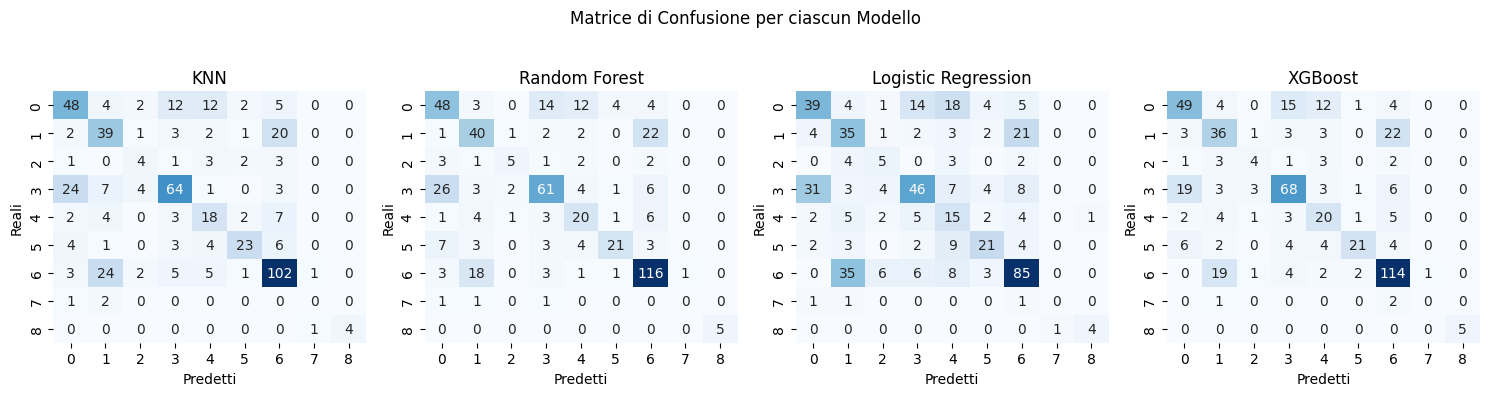


-------------------------------------------------
Il modello con le migliori prestazioni è: XGBoost
Accuracy: 0.6365
F1-score: 0.6342


In [59]:
# Individua il modello migliore basato su F1-score
best_model_name = max(model_results, key=lambda x: model_results[x][2])  # Basato su F1-score
best_model = model_results[best_model_name]

# Impostazioni per il grafico
fig, axes = plt.subplots(1, len(model_results), figsize=(15, 4))  # Griglia 1xN per le matrici di confusione
fig.suptitle("Matrice di Confusione per ciascun Modello")

# Creazione della matrice di confusione per ogni modello e visualizzazione in un subplot
for ax, (model_name, (model, accuracy, f1_score)) in zip(axes, model_results.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel("Predetti")
    ax.set_ylabel("Reali")

# Mostra i grafici
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Lascia spazio per il titolo principale
plt.show()

# Stampa le prestazioni del modello con F1-score più alto
print("\n-------------------------------------------------")
print(f"Il modello con le migliori prestazioni è: {best_model_name}")
print(f"Accuracy: {best_model[1]:.4f}")
print(f"F1-score: {best_model[2]:.4f}")

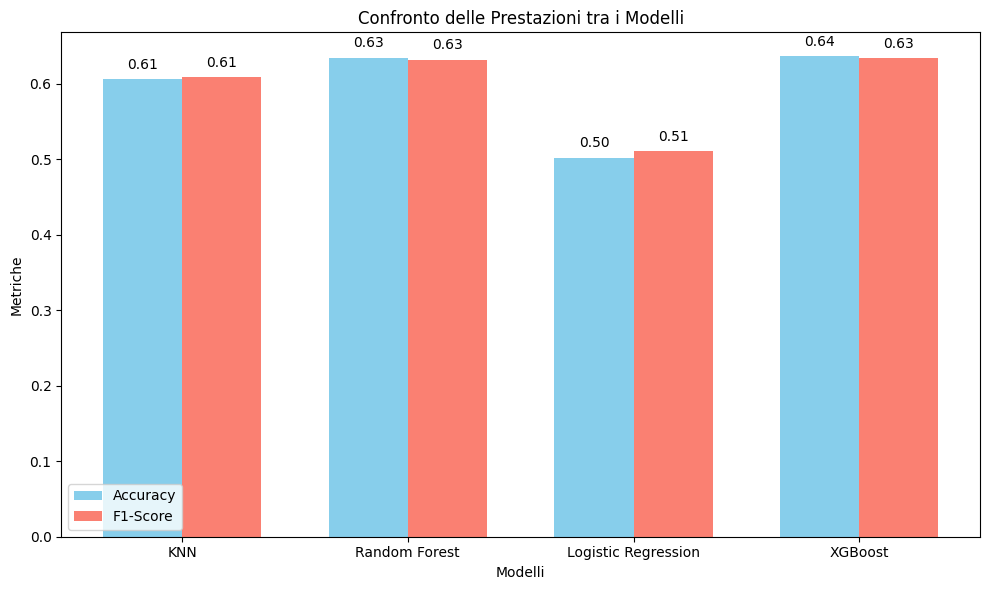

In [60]:
# Prepara i dati per il grafico
model_names = list(model_results.keys())
accuracies = [model_results[model][1] for model in model_names]
f1_scores = [model_results[model][2] for model in model_names]

# Definisce la posizione delle barre per ciascun modello
x = np.arange(len(model_names))
width = 0.35  # Larghezza delle barre

# Crea la figura e gli assi
fig, ax = plt.subplots(figsize=(10, 6))

# Grafico a barre per l'accuratezza e l'F1-score
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score', color='salmon')

# Aggiunge etichette, titolo e legenda
ax.set_xlabel("Modelli")
ax.set_ylabel("Metriche")
ax.set_title("Confronto delle Prestazioni tra i Modelli")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Aggiungi i valori in cima a ciascuna barra per maggiore leggibilità
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Mostra il grafico
plt.tight_layout()
plt.show()